In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit, cuda

In [2]:
def generate_data(function, point_count, x_min, x_max, std):
    x = np.linspace(x_min, x_max, point_count)
    y = function(x)
    y += np.random.random(point_count) * std - std / 2
    return x, y


In [3]:
x, y = generate_data(lambda x: 0.02*x**4 - 0.055*x**3 + 0.02*x - 0.01, 500, -3, 3, 0.1)

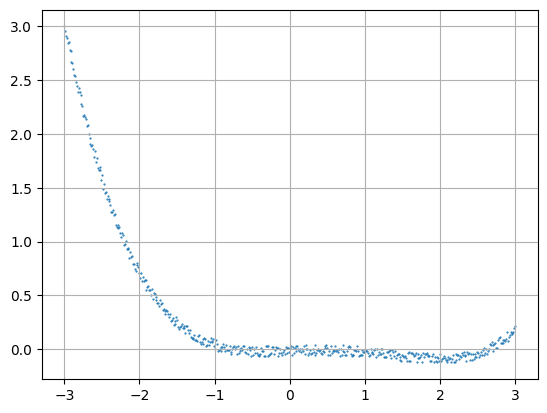

In [4]:
plt.scatter(x, y, s=0.3)
plt.grid()

In [5]:
@cuda.jit
def fitness(individuals, points, fitnesses):
    i = cuda.grid(1)
    if i < individuals.shape[0]:
        ind = individuals[i, :]
        err = 0
        for k in range(points.shape[0]):
            point = points[k, :]
            f_approx = 0
            for j in range(ind.shape[0]):
                f_approx += ind[j] * point[0] ** j
            if abs(f_approx - point[1]) > err:
                err = abs(f_approx - point[1])
        fitnesses[i] = err


In [6]:
@cuda.jit
def crossover(individuals, population_size, children, types, crosspoints, parent1, parent2):
    i = cuda.grid(1)
    if i < population_size:
        p1 = individuals[parent1[i], :]
        p2 = individuals[parent2[i], :]

        crossover_type = types[i]
        crosspoint = crosspoints[i]        

        j1 = p1[:crosspoint]
        j2 = p2[crosspoint:]
        j3 = p2[:crosspoint]
        j4 = p1[crosspoint:]

        if crossover_type:
            for j in range(crosspoint):
                children[i][j] = j1[j]
                children[i][crosspoint+j] = j2[j]
        else:
            for j in range(crosspoint):
                children[i][j] = j3[j]
                children[i][crosspoint+j] = j4[j]



In [7]:
def mutation(individuals):
    mutation_count = random.randint(1, individuals.shape[1])
    for i in range(mutation_count):
        idx = random.randint(0, individuals.shape[0] - 1)
        bits_count = random.randint(1, individuals.shape[1])
        gen_max = max(individuals[idx])
        for j in range(bits_count):
            individuals[idx, random.randint(0, individuals.shape[1] - 1)] += np.random.uniform(-gen_max, gen_max)
    return individuals


In [8]:
def selection(individuals, fitnesses):
    to_sort = zip(individuals, fitnesses)
    sorted_zip = sorted(to_sort, key=lambda x: x[1])
    list1, list2 = map(list, zip(*sorted_zip))
    return np.array(list1), np.array(list2)

In [10]:
def genetic_algorithm(points, degree, population_size, err, max_iter, initial = float("inf")):
    population = np.random.random((population_size, int(degree) + 1))
    best_fitness = initial
    points_dev = cuda.to_device(points)
    for i in range(max_iter):
        children = np.empty((population_size, population.shape[1]))
        population_dev = cuda.to_device(population[:population_size // 2, :])
        children_dev = cuda.to_device(children)
        crossover_types = []
        crosspoints = []
        parent1 = []
        parent2 = []
        for _ in range(population_size):
            crossover_types.append(random.randint(0, 1))
            crosspoints.append(random.randint(1, children.shape[1]))
            parent1.append(random.randint(0, population_dev.shape[0] - 1))
            parent2.append(random.randint(0, population_dev.shape[0] - 1))
        crossover_types_dev = cuda.to_device(crossover_types)
        crosspoints_dev = cuda.to_device(crosspoints)
        parent1_dev = cuda.to_device(parent1)
        parent2_dev = cuda.to_device(parent2)
        crossover[int(population_size // 1024) + 1, 1024](population_dev, population_size, children_dev, crossover_types_dev, crosspoints_dev, parent1_dev, parent2_dev)
        population = children_dev.copy_to_host()
        population = mutation(population)
        fitnesses = np.zeros(population.shape[0])
        fitnesses_dev = cuda.to_device(fitnesses)
        fitness[int(population_size // 1024) + 1, 1024](children_dev, points_dev, fitnesses_dev)
        current_fitnesses = fitnesses_dev.copy_to_host()
        population, current_fitnesses = selection(population, current_fitnesses)
        if i!= 0 and current_fitnesses[0] < best_fitness:
            best_fitness = current_fitnesses[0]
            best_ind = population[0, :]
        if best_fitness < err:
            break
    return best_ind, best_fitness

In [22]:
points = np.hstack([x.reshape(x.shape[0], 1), y.reshape(y.shape[0], 1)], dtype=np.float64)
params, err = genetic_algorithm(points, 4, 3000, 0.01, 10000, float("inf"))

c:\Python311\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


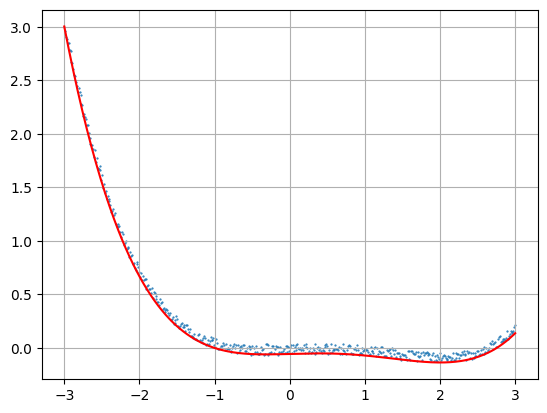

In [27]:
plt.scatter(x, y, s=0.3)
plt.plot(x, params[0] + params[1]*x + params[2]*x**2 + params[3]*x**3 + params[4]*x**4, c='r')
plt.grid()